In [1]:
import os
import cv2
import shutil
from more_itertools import chunked
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
import keras
from keras.utils.data_utils import get_file
from keras.utils import to_categorical
from keras import layers
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D,Dense
from keras.layers import Activation, Flatten, Dropout
from keras.callbacks import ModelCheckpoint
from keras import optimizers

Using TensorFlow backend.


## Data Preparatrion

In [2]:
#get list of files
_files = os.listdir("jpg")
#jpg only
_files = sorted([x for x in _files if x.endswith(".jpg")])

#to groups of 80
grouped_files = list(chunked(_files,80))

#create parent directory
parent_dir = "image"
if os.path.exists(parent_dir) == False:
    os.mkdir(parent_dir)
    
#create subfolder
labels = ['Daffodil', 'Snowdrop', 'LilyValley', 'Bluebell', 'Crocus', 'Iris', 'Tigerlily', 'Tulip', 'Fritillary', 'Sunflower', 'Daisy', 'ColtsFoot', 'Dandelion', 'Cowslip', 'Buttercup', 'Windflower', 'Pansy']
print ("creating data for: ",labels)
for label in labels:
    subfolder = os.path.join(parent_dir,label)
    if os.path.exists(subfolder) == False:
        os.mkdir(subfolder)
#copy files to subfolders
for i,files in enumerate(grouped_files):
    for file in files:
        orig = os.path.join("jpg",file)
        dest = os.path.join(parent_dir,labels[i],file)
        shutil.copy2(orig,dest)

creating data for:  ['Daffodil', 'Snowdrop', 'LilyValley', 'Bluebell', 'Crocus', 'Iris', 'Tigerlily', 'Tulip', 'Fritillary', 'Sunflower', 'Daisy', 'ColtsFoot', 'Dandelion', 'Cowslip', 'Buttercup', 'Windflower', 'Pansy']


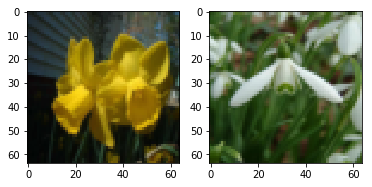

In [3]:
plt.subplot(1,2,1)
img = load_img("image/Daffodil/image_0020.jpg",target_size=(64,64))
x = img_to_array(img)/255.
plt.imshow(x)

plt.subplot(1,2,2)
img = load_img("image/Snowdrop/image_0082.jpg",target_size=(64,64))
x = img_to_array(img)/255.
plt.imshow(x)
plt.show()

In [4]:
x = []
y = []
labels = ['Daffodil', 'Snowdrop', 'LilyValley', 'Bluebell', 'Crocus', 'Iris', 'Tigerlily', 'Tulip', 'Fritillary', 'Sunflower', 'Daisy', 'ColtsFoot', 'Dandelion', 'Cowslip', 'Buttercup', 'Windflower', 'Pansy']

for i,label in enumerate(labels):
    folder = os.path.join("image",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        img_path = os.path.join(folder,file)
        img = load_img(img_path,target_size=(64,64))
        img = img_to_array(img)/255.
        #print(img)
        x.append(img)
        y.append(i)

x = np.array(x)
y = np.array(y)       
y = to_categorical(y)

In [5]:
train_x, valid_x, train_y, valid_y = train_test_split(x,y,random_state=1,test_size=0.2)

print(train_x.shape,train_y.shape)
print(valid_x.shape,valid_y.shape)

(1088, 64, 64, 3) (1088, 17)
(272, 64, 64, 3) (272, 17)


## Solution Model

In [6]:
model = Sequential()

model.add(Conv2D(32, (5, 5), padding='same', input_shape=train_x.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (5, 5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

#     model.add(Flatten())
model.add(GlobalAveragePooling2D())

model.add(Dense(512, activation='tanh'))
model.add(Dropout(0.5)) 

#    model.add(Dense(256, activation='tanh'))
#    model.add(Dropout(0.25)) 

model.add(Dense(128, activation='tanh'))
model.add(Dropout(0.4)) 

model.add(Dense(17))
model.add(Activation('softmax'))


In [7]:
opt=optimizers.Adam(lr=0.001)

In [8]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        2432      
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 96)        76896     
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 96)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 96)        0         
__________

In [10]:
data_generator = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                                    height_shift_range=0.1, shear_range=0.2,
                                    zoom_range=0.2,horizontal_flip=True, fill_mode="nearest")

In [11]:
checkpointer = ModelCheckpoint(filepath='./weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

In [12]:
hist=model.fit_generator(data_generator.flow(train_x, train_y, batch_size=500),
                                               steps_per_epoch=189, epochs=60, verbose=2, 
                                               validation_data=(valid_x, valid_y))

Epoch 1/60
 - 65s - loss: 2.0344 - acc: 0.3081 - val_loss: 1.5751 - val_acc: 0.5000
Epoch 2/60
 - 62s - loss: 1.4809 - acc: 0.4942 - val_loss: 1.2841 - val_acc: 0.5956
Epoch 3/60
 - 63s - loss: 1.2285 - acc: 0.5811 - val_loss: 1.1065 - val_acc: 0.6360
Epoch 4/60
 - 62s - loss: 1.0417 - acc: 0.6406 - val_loss: 0.9962 - val_acc: 0.6765
Epoch 5/60
 - 62s - loss: 0.9222 - acc: 0.6814 - val_loss: 0.9432 - val_acc: 0.6838
Epoch 6/60
 - 62s - loss: 0.8102 - acc: 0.7193 - val_loss: 0.8640 - val_acc: 0.7206
Epoch 7/60
 - 62s - loss: 0.7230 - acc: 0.7519 - val_loss: 0.9185 - val_acc: 0.6985
Epoch 8/60
 - 63s - loss: 0.6491 - acc: 0.7748 - val_loss: 0.8026 - val_acc: 0.7243
Epoch 9/60
 - 63s - loss: 0.5756 - acc: 0.8022 - val_loss: 0.8415 - val_acc: 0.7426
Epoch 10/60
 - 62s - loss: 0.5088 - acc: 0.8257 - val_loss: 0.7702 - val_acc: 0.7610
Epoch 11/60
 - 63s - loss: 0.4671 - acc: 0.8421 - val_loss: 0.7997 - val_acc: 0.7757
Epoch 12/60
 - 63s - loss: 0.4301 - acc: 0.8508 - val_loss: 0.7952 - val_a

In [13]:
model.evaluate(valid_x,valid_y)

272/272 [==============================] - 0s 426us/step


[0.99709957838058472, 0.81617647058823528]

## Visualization 

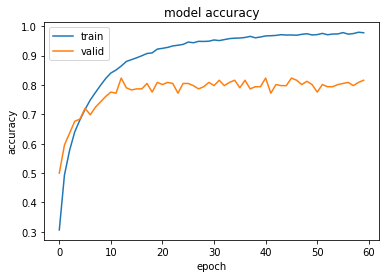

In [14]:
# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()


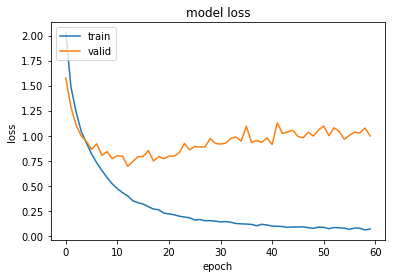

In [15]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

## Testing

In [16]:
def predict_flower(img):
    img=img[...,::-1]
    img=cv2.resize(img, (64, 64))
    plt.imshow(img)
    x = np.expand_dims(img, axis=0)/255.
    prediction=model.predict(x)
    #print(prediction)
    return labels[np.argmax(prediction)]

Pansy


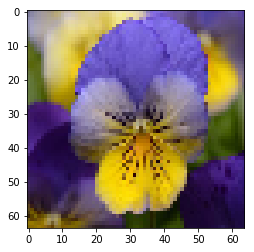

In [17]:
print(predict_flower(cv2.imread('test/pansy.jpg')))


Tigerlily


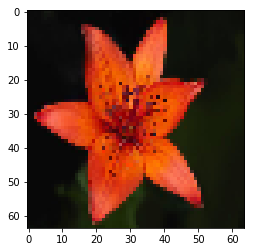

In [18]:
print(predict_flower(cv2.imread('test/tiger_lily.jpg')))

Iris


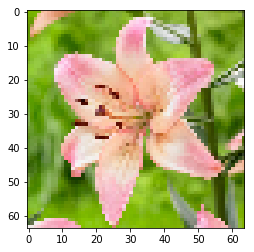

In [19]:
print(predict_flower(cv2.imread('test/f1.jpg')))

## Benchmark Model (training only prediction head)

In [20]:
core = VGG16(weights="imagenet",input_shape=(64,64,3),include_top=False)

#add the dense layers by functional api
x = layers.Flatten()(core.output)
x = layers.Dense(512,activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512,activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(17)(x)
outputs = layers.Activation("softmax")(x)

#compile model
model_benchmark = Model(inputs=core.input,outputs=outputs)

#freeze the core model layer
for layer in core.layers:
    layer.trainable = False
    
model_benchmark.compile(loss="categorical_crossentropy",optimizer="adam", metrics=["acc"])

model_benchmark.summary()

58892288/58889256 [==============================] - 12s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_poo

In [21]:
checkpointer = ModelCheckpoint(filepath='./weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

In [22]:
hist1=model_benchmark.fit_generator(data_generator.flow(train_x, train_y, batch_size=64),
                                               steps_per_epoch=189, epochs=30, verbose=2, 
                                               validation_data=(valid_x, valid_y))

Epoch 1/30
 - 26s - loss: 1.6129 - acc: 0.4827 - val_loss: 0.9905 - val_acc: 0.6765
Epoch 2/30
 - 25s - loss: 0.9228 - acc: 0.6955 - val_loss: 0.8298 - val_acc: 0.7353
Epoch 3/30
 - 25s - loss: 0.7416 - acc: 0.7502 - val_loss: 0.8139 - val_acc: 0.7206
Epoch 4/30
 - 25s - loss: 0.6257 - acc: 0.7910 - val_loss: 0.8153 - val_acc: 0.7463
Epoch 5/30
 - 25s - loss: 0.5648 - acc: 0.8134 - val_loss: 0.8769 - val_acc: 0.7279
Epoch 6/30
 - 25s - loss: 0.5140 - acc: 0.8249 - val_loss: 0.8145 - val_acc: 0.7574
Epoch 7/30
 - 25s - loss: 0.4661 - acc: 0.8423 - val_loss: 0.8064 - val_acc: 0.7904
Epoch 8/30
 - 25s - loss: 0.4399 - acc: 0.8535 - val_loss: 0.8262 - val_acc: 0.7537
Epoch 9/30
 - 25s - loss: 0.4125 - acc: 0.8621 - val_loss: 0.8387 - val_acc: 0.7574
Epoch 10/30
 - 25s - loss: 0.4020 - acc: 0.8687 - val_loss: 0.8518 - val_acc: 0.7243
Epoch 11/30
 - 25s - loss: 0.3750 - acc: 0.8738 - val_loss: 0.9329 - val_acc: 0.7500
Epoch 12/30
 - 25s - loss: 0.3488 - acc: 0.8811 - val_loss: 0.8448 - val_a

In [23]:
model_benchmark.evaluate(valid_x,valid_y)

272/272 [==============================] - 1s 4ms/step


[0.97976741370032816, 0.76102941176470584]

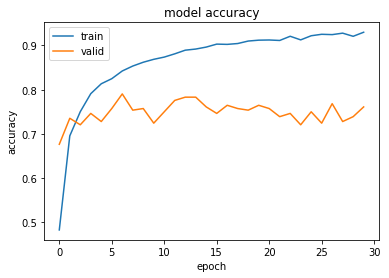

In [24]:
# summarize history for accuracy
plt.plot(hist1.history['acc'])
plt.plot(hist1.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()


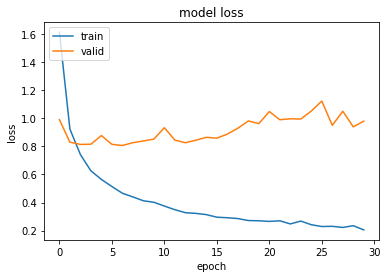

In [25]:
# summarize history for loss
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

## Conclusion

The solution model is overfitting.We might get better performance if we:
 - train the model for longer duration(increase the number of epochs)
 - tune the hyperparameters such as learning rate and batch size
